In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from albumentations import RandomRotate90
from tensorflow.keras import mixed_precision
import gc

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

2024-05-03 16:02:23.493814: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-03 16:02:23.494644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-03 16:02:23.644373: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 16:02:23.644425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 70 deviceMemorySize: 12.00GiB deviceMemoryBandwidth: 849.46GiB/s
2024-05-03 16:02:23.644453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-03 16:02:23.645913: I tensorflow/stream_executor/platfo

In [4]:
def Read_Data(path,is_train = True):
  temp = []
  updated_path = os.path.join(path,"data","VOC2007","ImageSets","Segmentation","train.txt" if is_train else "val.txt")
  with open(updated_path,"r") as file_:
    Instances = file_.read().split()
    for img in Instances:
      path_img = os.path.join(path,"data","VOC2007","JPEGImages",img+".jpg")
      path_label = os.path.join(path,"data","VOC2007","SegmentationClass",img+".png")
      temp.append([path_img,path_label])
  return temp

Read_Data("")

[['data/VOC2007/JPEGImages/000032.jpg',
  'data/VOC2007/SegmentationClass/000032.png'],
 ['data/VOC2007/JPEGImages/000033.jpg',
  'data/VOC2007/SegmentationClass/000033.png'],
 ['data/VOC2007/JPEGImages/000042.jpg',
  'data/VOC2007/SegmentationClass/000042.png'],
 ['data/VOC2007/JPEGImages/000061.jpg',
  'data/VOC2007/SegmentationClass/000061.png'],
 ['data/VOC2007/JPEGImages/000129.jpg',
  'data/VOC2007/SegmentationClass/000129.png'],
 ['data/VOC2007/JPEGImages/000187.jpg',
  'data/VOC2007/SegmentationClass/000187.png'],
 ['data/VOC2007/JPEGImages/000250.jpg',
  'data/VOC2007/SegmentationClass/000250.png'],
 ['data/VOC2007/JPEGImages/000256.jpg',
  'data/VOC2007/SegmentationClass/000256.png'],
 ['data/VOC2007/JPEGImages/000528.jpg',
  'data/VOC2007/SegmentationClass/000528.png'],
 ['data/VOC2007/JPEGImages/000549.jpg',
  'data/VOC2007/SegmentationClass/000549.png'],
 ['data/VOC2007/JPEGImages/000559.jpg',
  'data/VOC2007/SegmentationClass/000559.png'],
 ['data/VOC2007/JPEGImages/00064

In [5]:
path = ''
Train = Read_Data(path=path,is_train=True)
Val = Read_Data(path=path,is_train=False)

In [6]:
Train = tf.random.shuffle(Train)
Val = tf.random.shuffle(Val)

2024-05-03 16:02:26.362889: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 16:02:26.364889: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-03 16:02:26.365169: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 16:02:26.365203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 70 deviceMemorySize: 12.00GiB deviceMemoryBandwidth: 84

tf.Tensor(
[[b'data/VOC2007/JPEGImages/007168.jpg'
  b'data/VOC2007/SegmentationClass/007168.png']
 [b'data/VOC2007/JPEGImages/006004.jpg'
  b'data/VOC2007/SegmentationClass/006004.png']
 [b'data/VOC2007/JPEGImages/009562.jpg'
  b'data/VOC2007/SegmentationClass/009562.png']
 [b'data/VOC2007/JPEGImages/000528.jpg'
  b'data/VOC2007/SegmentationClass/000528.png']
 [b'data/VOC2007/JPEGImages/006605.jpg'
  b'data/VOC2007/SegmentationClass/006605.png']
 [b'data/VOC2007/JPEGImages/007417.jpg'
  b'data/VOC2007/SegmentationClass/007417.png']
 [b'data/VOC2007/JPEGImages/009392.jpg'
  b'data/VOC2007/SegmentationClass/009392.png']
 [b'data/VOC2007/JPEGImages/007836.jpg'
  b'data/VOC2007/SegmentationClass/007836.png']
 [b'data/VOC2007/JPEGImages/000032.jpg'
  b'data/VOC2007/SegmentationClass/000032.png']
 [b'data/VOC2007/JPEGImages/009832.jpg'
  b'data/VOC2007/SegmentationClass/009832.png']
 [b'data/VOC2007/JPEGImages/006660.jpg'
  b'data/VOC2007/SegmentationClass/006660.png']
 [b'data/VOC2007/JPEG

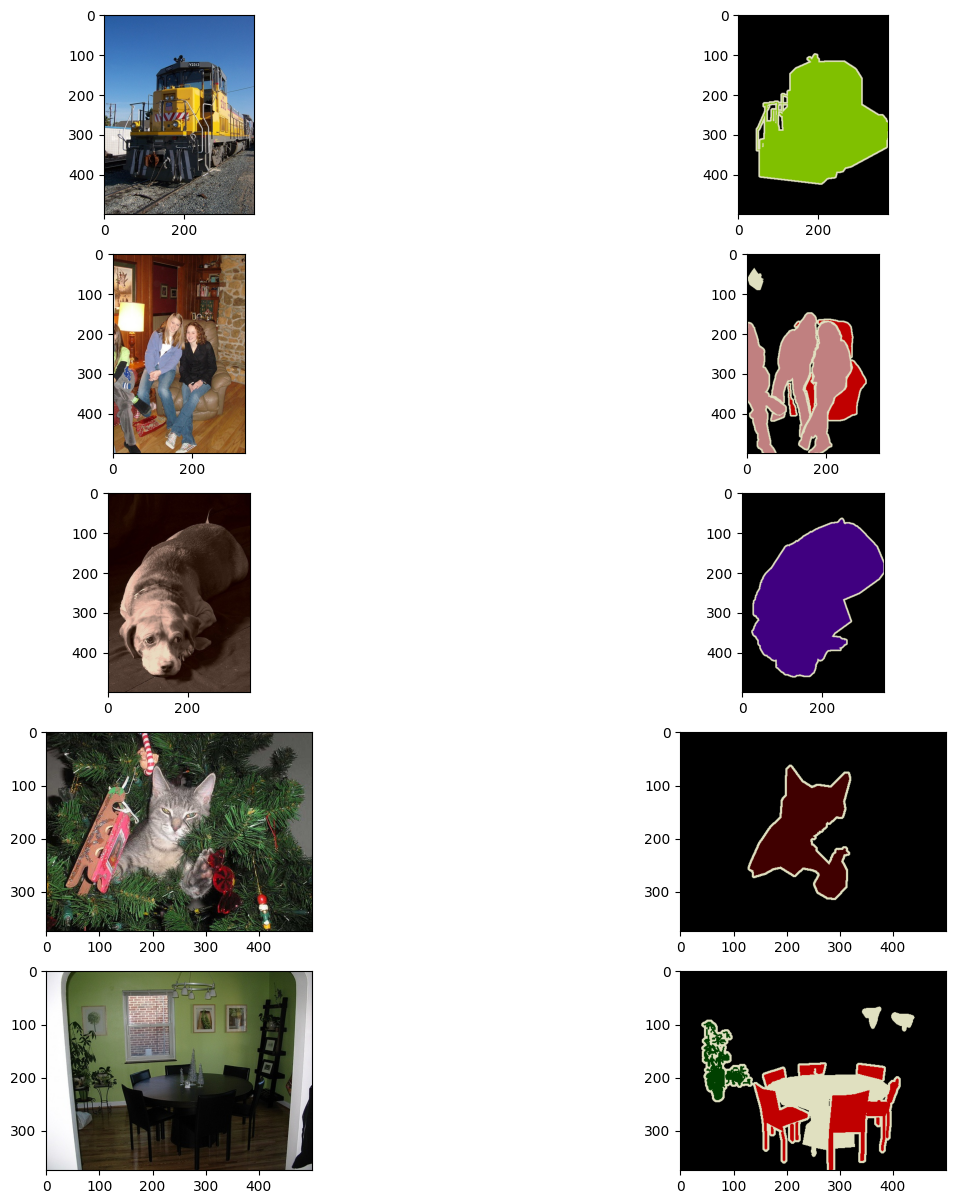

In [7]:
plt.figure(figsize=(15,15))
idx = 0
img = 0
mask = 0
print(Train)
for instance in Train[:5].numpy():
  plt.subplot(5,2,idx+1)  
  img = Image.open(instance[0])
  plt.imshow(img)
  plt.subplot(5,2,idx+2)  
  mask = Image.open(instance[1])
  plt.imshow(mask)
  idx += 2

In [8]:
num_classes = 21
Img_Width,Img_Height = 224,224
Train = tf.data.Dataset.from_tensor_slices(Train)
Val = tf.data.Dataset.from_tensor_slices(Val)
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


2024-05-03 16:02:28.349575: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-03 16:02:28.349876: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


In [9]:
def Create_Mask(Img):
  Seg_Labels = np.zeros((Img.shape[0],Img.shape[1],num_classes),dtype=np.float16)
  for class_ in range(num_classes):
    Seg_Labels[:,:,class_] = (Img == class_)
  return tf.cast(Seg_Labels,dtype=tf.float16)

In [10]:
def Create_PreProcess_Mask_Img(Instance):
 
  Img = Image.open(Instance[0].numpy())
  Img = Img.resize((Img_Width,Img_Height),resample = Image.BILINEAR)
  Img = np.asarray(Img)

  Mask = Image.open(Instance[1].numpy())
  Mask = Mask.resize((Img_Width,Img_Height),resample = Image.BILINEAR)
  Mask = np.asarray(Mask)   
   
  # Since Mask is in 'P' mode it will automatically convert to labels using Color Palette 

  Normalization = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

  if tf.random.uniform(()) > 0.5:  # Applying data Augmentation
    aug = RandomRotate90(p=0.5)
    Augmented = aug(image = Img,mask = Mask)

    Img = Augmented["image"]
    Mask = Augmented["mask"]
  
  return Normalization(Img),Create_Mask(Mask)

In [11]:
def Preprocess(Instance):
  Img,Mask = tf.py_function(Create_PreProcess_Mask_Img,[Instance],[tf.float16,tf.float16])
  return tf.ensure_shape(Img,[None,None,3]),tf.ensure_shape(Mask,[None,None,num_classes])  
  #tf.ensure_shape returns the matrix if shape matches else error

In [12]:
def DataLoader(dataset,BATCH_SIZE = 2,BUFFER_SIZE = 2):
  data = dataset.map(Preprocess,num_parallel_calls = tf.data.AUTOTUNE)
  data = data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(1)
  data = data.prefetch(buffer_size = tf.data.AUTOTUNE)
  return data

In [13]:
Train = DataLoader(Train)
Val = DataLoader(Val)

for batch_idx, (images, labels) in enumerate(Train):
    print("Batch", batch_idx)
    print("Images shape:", images)  # Shape of the batch of images (batch_size, channels, height, width)
    print("Labels:", labels)  # Labels for the batch of images

2024-05-03 16:02:33.066843: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-03 16:02:33.067127: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3393625000 Hz


Batch 0
Images shape: tf.Tensor(
[[[[0.5728   0.6704   0.7803  ]
   [0.5845   0.6943   0.792   ]
   [0.5806   0.698    0.796   ]
   ...
   [0.392    0.1255   0.0392  ]
   [0.396    0.1333   0.0549  ]
   [0.4197   0.1294   0.0549  ]]

  [[0.5845   0.702    0.8076  ]
   [0.5767   0.6904   0.792   ]
   [0.5806   0.682    0.796   ]
   ...
   [0.392    0.1333   0.05096 ]
   [0.4      0.1411   0.05884 ]
   [0.4119   0.1333   0.0549  ]]

  [[0.5728   0.6904   0.796   ]
   [0.5728   0.682    0.7803  ]
   [0.5767   0.6704   0.7607  ]
   ...
   [0.3843   0.1294   0.0392  ]
   [0.3882   0.1333   0.04315 ]
   [0.4      0.1372   0.04706 ]]

  ...

  [[0.5137   0.306    0.1019  ]
   [0.4902   0.2744   0.0784  ]
   [0.5254   0.306    0.1255  ]
   ...
   [0.5527   0.4      0.2118  ]
   [0.5293   0.3843   0.2039  ]
   [0.502    0.3726   0.1843  ]]

  [[0.5645   0.3804   0.1333  ]
   [0.5176   0.3215   0.0941  ]
   [0.498    0.2783   0.1059  ]
   ...
   [0.537    0.396    0.1921  ]
   [0.5137   0.3804  

In [14]:
Q = []
for X,Y in Val.take(1):
  print(X.shape)
  Q = Y
  print(Y.shape)

(2, 224, 224, 3)
(2, 224, 224, 21)


2024-05-03 16:02:35.363271: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
Q.dtype

tf.float16

In [16]:
# Lets Create Our FCN Model
def FCN_VGG8():

  Input = tf.keras.layers.Input(shape = [Img_Width,Img_Height,3])
  Conv1 = tf.keras.layers.Conv2D(64,kernel_size=3,strides = 1,padding="same",activation="relu")(Input)
  Conv2 = tf.keras.layers.Conv2D(64,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv1)
  Pool1 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv2)

  Conv3 = tf.keras.layers.Conv2D(128,kernel_size=3,strides = 1,padding="same",activation="relu")(Pool1)
  Conv4 = tf.keras.layers.Conv2D(128,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv3)
  Pool2 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv4)

  Conv5 = tf.keras.layers.Conv2D(256,kernel_size=3,strides = 1,padding="same",activation="relu")(Pool2)
  Conv6 = tf.keras.layers.Conv2D(256,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv5)
  Conv7 = tf.keras.layers.Conv2D(256,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv6)
  Pool3 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv7)

  Conv8 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Pool3)
  Conv9 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv8)
  Conv10 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv9)
  Pool4 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv10)

  Conv11 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Pool4)
  Conv12 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv11)
  Conv13 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv12)
  Pool5 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv13)

  # Fully Convolutional Layer

  FC_Layer = tf.keras.layers.Conv2D(4096,kernel_size=7,activation="relu")(Pool5)
  FC_Drop = tf.keras.layers.Dropout(rate=0.5)(FC_Layer)
  FC_Layer2 = tf.keras.layers.Conv2D(4096,kernel_size=1,activation="relu")(FC_Drop)
  FC_Drop2 = tf.keras.layers.Dropout(rate=0.5)(FC_Layer2)

  # Classification Score Layer
  Score = tf.keras.layers.Conv2D(num_classes,kernel_size=1,activation="relu")(FC_Drop2)
 

  #Upsample Pool4

  Upscore = tf.keras.layers.Conv2DTranspose(num_classes,kernel_size=4,strides=2,kernel_initializer="zeros")(Score)
  
  Conv_Scale = tf.keras.layers.Conv2D(num_classes,kernel_size=1)(Pool4)
  Cropped = tf.keras.layers.Cropping2D(cropping=(5,5))(Conv_Scale)

  Fused = tf.keras.layers.add([Cropped,Upscore])
  
  Upsampled_Pool4 = tf.keras.layers.Conv2DTranspose(num_classes,kernel_size=4,strides=2,kernel_initializer="zeros")(Fused)

  
  # Upsample Pool3

  Conv_Scale2 = tf.keras.layers.Conv2D(num_classes,kernel_size=1)(Pool3)
  Cropped2 = tf.keras.layers.Cropping2D(cropping=(9,9))(Conv_Scale2)
  Fused2 = tf.keras.layers.add([Cropped2,Upsampled_Pool4])

  Upsampled_Pool3 = tf.keras.layers.Conv2DTranspose(num_classes,kernel_size=128,strides=16,kernel_initializer="zeros")(Fused2)

  # Score per Pixel

  Score = tf.keras.layers.Cropping2D(cropping=(24,24))(Upsampled_Pool3)
  Score = tf.keras.layers.Softmax(dtype = "float32")(Score)

  return tf.keras.Model(inputs = Input,outputs = Score)


In [17]:
model = FCN_VGG8()

In [18]:
!uv pip install pydot graphviz 

tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True)

Audited 2 packages in 3ms
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
VGG16 = tf.keras.applications.vgg16.VGG16(weights='imagenet')
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

2024-05-03 16:02:44.162640: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


In [21]:
model.layers[:19]

In [22]:
for i in model.layers:
    print(i.dtype_policy)

<Policy "float32">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "float32">


In [23]:
for i in range(19):
  model.layers[i].set_weights(VGG16.layers[i].get_weights())

In [24]:
root_dir = os.path.join(os.curdir,"my_logs")

def get_path():
    import time
    id_ = time.strftime("run_%Y_%m_%D_%H_%M_%S")
    return os.path.join(root_dir,id_)

board_log_path = get_path()

In [25]:
for layers in model.layers[:19]:
  layers.trainable = False

In [26]:
EarlyStop = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights=True)
checkpoint_path = os.path.join(os.curdir,"checkpoint")
Checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True)
Tensorboard = tf.keras.callbacks.TensorBoard(board_log_path)

MeanIou = tf.keras.metrics.MeanIoU(num_classes=21)

2024-05-03 16:02:52.602685: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-05-03 16:02:52.602716: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-05-03 16:02:52.603064: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2024-05-03 16:02:52.612161: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2024-05-03 16:02:52.813004: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-05-03 16:02:52.813108: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [27]:
gc.collect()
gc.enable()

In [28]:
tf.keras.backend.clear_session()

In [29]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4,momentum=0.9),loss=tf.keras.losses.categorical_crossentropy,metrics=[MeanIou])

In [30]:
Epochs = 100
Batchsize = 2

history = model.fit(Train,validation_data=Val,batch_size=Batchsize,epochs=Epochs,callbacks=[EarlyStop,Checkpoint,Tensorboard])

Epoch 1/100


2024-05-03 16:02:57.854520: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10,8))
plt.grid('True')
plt.savefig("Learning_Curve_Model1.png")
plt.show()

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
Epochs = 300
Batchsize = 2

history = model.fit(Train,validation_data=Val,batch_size=Batchsize,epochs=Epochs,callbacks=[EarlyStop,Checkpoint,Tensorboard])

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10,8))
plt.grid('True')
plt.savefig("Learning_Curve_Model1.png")
plt.show()